## Hybrid Ice Stream Split

Trying to change the bed geometry to slope in both directions, and include accumulation zone instead of boundary condition.

Import firedrake and other tools.

In [1]:
import firedrake
import icepack
import matplotlib.pyplot as plt
import numpy as np

/home/sorenthompson/firedrake/src/ngsPETSc/ngsPETSc/eps.py:10: UserWarning: Import Warning: it was not possible to import SLEPc
  warnings.warn("Import Warning: it was not possible to import SLEPc")
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Define bed parameters, initialize mesh, and set up function spaces for scalars (Q) and vectors (V).

In [2]:
Lx_land = 200e3
Lx_land_accum = 10e3
Lx_water_accum = 10e3
Lx_water = 125e3

Lx_l = Lx_land + Lx_land_accum
Lx_r = Lx_water_accum + Lx_water
Lx = Lx_l + Lx_r

nx_land = 72
nx_accum = 72
nx_water = 72

nx = nx_land + nx_accum + nx_water

# mesh1d = firedrake.IntervalMesh(nx, -Lx_l, Lx_r)
mesh1d = firedrake.IntervalMesh(nx, 0, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers = 1)

Q = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="R", vdegree=0)
V = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="GL", vdegree=2)

Import a couple constant values from icepack.

In [3]:
from icepack.constants import(
    ice_density as rho_ice,           # ρ_I | 9.21e-19
    water_density as rho_water,       # ρ_W | 1.03e-18
    weertman_sliding_law as weertman, # m   | 3.0
    gravity as g,                     # g   | 9.77e15
)

Set up bed geometry.

Bed is defined in three sections based on two gaussian curves on either side of a flat icefield.

$$
bed= a * e^{-\frac{(x-b)^2}{2c^2}} + d
$$

a = maximum bed height - minimum bed height

b = position of border between accumulation and sloping areas (`-Lx_land_accum` and `Lx_water_accum`)

c = slope control aka width of curve. `Lx_land/3` and `Lx_water/3.5` are currently used.

d = minimum bed height

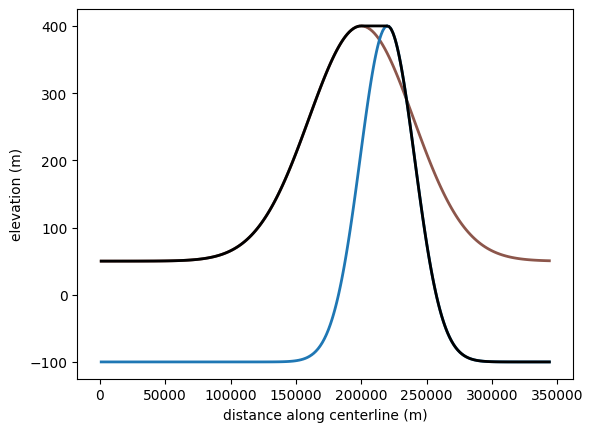

In [4]:
from firedrake import max_value, min_value
from firedrake import conditional, eq, ne, le, ge, lt, gt

x,z = firedrake.SpatialCoordinate(mesh)

b_min_land = 50
b_accum = 400
b_min_water = -100

# b_land = (b_accum - b_min_land) * firedrake.exp(-((x+Lx_land_accum)**2)/(2*(Lx_land/5)**2)) + b_min_land
# b_water = (b_accum - b_min_water) * firedrake.exp(-((x-Lx_water_accum)**2)/(2*(Lx_water/4)**2)) + b_min_water

# b = firedrake.interpolate(conditional(lt(x, -Lx_land_accum),b_land,
#                                       conditional(lt(x, Lx_water_accum), b_accum, b_water)),Q)

b_land = (b_accum - b_min_land) * firedrake.exp(-((x-Lx_land)**2)/(2*(Lx_land/5)**2)) + b_min_land
b_water = (b_accum - b_min_water) * firedrake.exp(-((x-(Lx-Lx_water))**2)/(2*(Lx_water/6)**2)) + b_min_water

b_land_graph = firedrake.interpolate(b_land, Q)
b_water_graph = firedrake.interpolate(b_water, Q)
b = firedrake.interpolate(conditional(lt(x, Lx_land),b_land,
                                      conditional(lt(x, Lx - Lx_water), b_accum, b_water)),Q)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")
firedrake.plot(icepack.depth_average(b_land_graph), edgecolor="tab:brown", axes=axes)
firedrake.plot(icepack.depth_average(b_water_graph), edgecolor="tab:blue", axes=axes)
firedrake.plot(icepack.depth_average(b), axes=axes);

Calculate initial height and surface.

$\tau_D$ = driving stress

$$
\tau_D = -\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}
$$

where $g = $ gravity

$h_{in} = $ incoming height

$\frac{\delta s}{\delta x}$ = surface slope

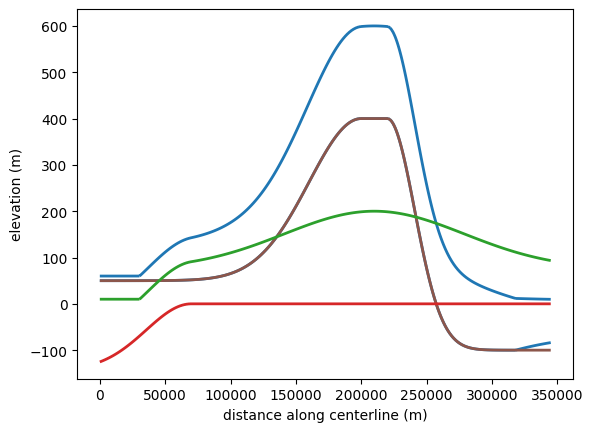

In [5]:
height_max = 200
height_min = 75
# height_x = (height_max - height_min) * firedrake.exp(-(x)**2)/(2*((Lx_l+Lx_r)/5)**2)) + height_min
height_x = (height_max - height_min) * firedrake.exp(-((x-(Lx_l))**2)/(2*((Lx_l+Lx_r)/5)**2)) + height_min

# Create a terminus at the end of the 
# land_terminus_end = -Lx_l * 1.05
# land_terminus_start = -Lx_land_accum - 0.75 * Lx_land
# terminus_adjust = (height_max - height_min) * (firedrake.exp(-((x-(land_terminus_start))**2)/(2*((Lx_l+Lx_r)/10)**2)) - 1)
# t_adj_1 = firedrake.interpolate(terminus_adjust, Q)
# t_adj_2 = firedrake.interpolate(conditional(lt(x, land_terminus_start), terminus_adjust, 0), Q)

land_terminus_end = 0
land_terminus_start = Lx_land * 0.35
terminus_adjust = (height_max - height_min*.75) * (firedrake.exp(-((x-(land_terminus_start))**2)/(2*((Lx_l+Lx_r)/10)**2)) - 1)
t_adj = firedrake.interpolate(conditional(lt(x, land_terminus_start), terminus_adjust, 0), Q)

h0 = firedrake.interpolate(height_x + t_adj, Q)
h0 = firedrake.interpolate(conditional(lt(h0, 10), 10, h0), Q) # Level out end of terminus
s0 = icepack.compute_surface(thickness=h0, bed=b)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

zb0 = firedrake.interpolate(s0-h0, Q)
firedrake.plot(icepack.depth_average(zb0), edgecolor="tab:blue", axes = axes);
firedrake.plot(icepack.depth_average(s0), edgecolor="tab:blue", axes = axes);
firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes);
firedrake.plot(icepack.depth_average(h0), edgecolor="tab:green", axes=axes);
firedrake.plot(icepack.depth_average(t_adj), edgecolor="tab:red", axes=axes);

Estimate intial velocities, negative in the land-terminating area and positive in the water-terminating area. It is assumed that the dividing line is at position $x=0$. 

$$
u_x = u_{in} + (u_{out} - u_{in}) * \left(\frac{x}{Lx}\right)^2
$$

Just an interpolation between $u_{in}$ and $u_{out}$ using a square.

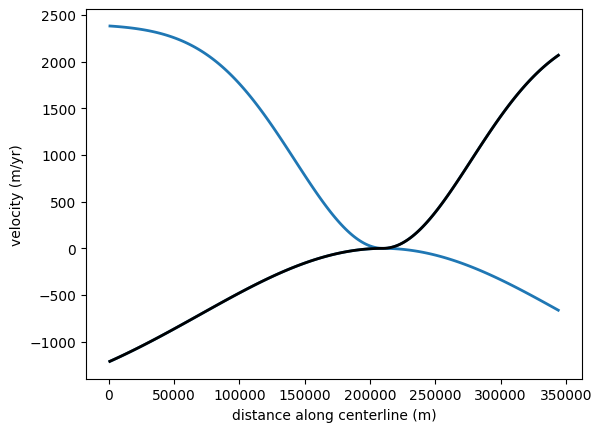

In [6]:
u_out_land = -1800
u_out_water = 2400

velocity_x_land = -u_out_land * firedrake.exp(-((x-Lx_l)**2)/(2*(Lx_l/1.5)**2)) + u_out_land
velocity_x_water = -u_out_water * firedrake.exp(-((x-Lx_l)**2)/(2*(Lx_r/2)**2)) + u_out_water

u0_l = firedrake.interpolate(velocity_x_land, V)
u0_r = firedrake.interpolate(velocity_x_water, V)
u0 = firedrake.interpolate(conditional(lt(x,Lx_l),u0_l, u0_r),Q) # X is old and needs to be fixed

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0_l), edgecolor="tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(u0_r), edgecolor="tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(u0), axes=axes);

Set up icepack values.

water pressure = water density * gravity * amount of ice under the water line (elevation = 0)
ice pressure = ice density * gravity * ice height
phi = ramping function for friction.
- If no water pressure, then phi = 1.
- If ice pressure equals water pressure, then phi = 0.

$C$ = Friction Coeff

$$
C = (0.95 - 0.05 \frac{x}{Lx}) \times \frac{\tau_D}{u_{in}^{1/3}}
$$

where $\tau_D =$ driving stress
and $u_{in} = $ incoming velocity at source

Expanding the driving stress, this is

$$
C = -\left(0.95 - 0.05 \frac{x}{Lx}\right) \times \frac{\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}}{u_{in}^{1/3}}
$$

$C$ decreases slightly along length, then is a ratio of driving stress and incoming velocity

In [54]:
# Temperature = firedrake.Constant(255.0) # -18 deg C
Temperature = firedrake.Constant(272.0) # -1 deg C
A = icepack.rate_factor(Temperature) # flow rate factor

## Calculate slope, roundabout method using numpy but I don't see any built-in gradient functions
## Still needs to be fixed for starting at 0
from firedrake import grad, dx
import numpy as np
import xarray
from scipy.interpolate import interp1d

def Friction_Coeff(s_src, Lx_src, Q_src):
    surface_data = s_src.dat.data
    surface_slope_np = np.gradient(surface_data)
    linspace_slope = np.linspace(0, Lx_src, len(surface_slope_np), endpoint=True)
    temp_slope = xarray.DataArray(surface_slope_np, [linspace_slope],'x')
    # I don't think the gradient function takes the x distance into account, the slope is way too large.
    # So, tune the slope down to account for this.
    surface_slope = icepack.interpolate(temp_slope*0.002, Q_src)
    
    surface_slope.dat.data[-1] = temp_slope[-1]
    
    tau_D = firedrake.interpolate(rho_ice*g*height_max*abs(surface_slope), Q_src)
    C_src_0 = firedrake.interpolate(0.95 * tau_D / (20 ** (1/weertman)), Q_src)

    # Add a minimum C value, with edges smoothed with an exponential interpolation function
    C_min = 0.001
    C_src_1 = firedrake.interpolate((C_min*2+(C_src_0 - C_min)*(1-(1/(1+firedrake.exp((C_src_0*2 - C_min)*600))))), Q_src)
    
    # C_src_1 = firedrake.interpolate(firedrake.Constant(0.0147*0.4), Q)
    # C = firedrake.interpolate(0.95 * tau_D/20 ** (1/weertman), Q)

    # fig, axes = plt.subplots()
    # axes.set_xlabel("distance along centerline(m)")
    # axes.set_ylabel("Surface Slope")
    # firedrake.plot(icepack.depth_average(surface_slope), edgecolor="tab:blue", axes=axes);

    ## Scaling down C lets negative velocities get bigger, but the positive velocities get way too big.
    # Using a constant C seems to have the same issue - something in the friction implemetation is causing issues.
    C_src_1 = firedrake.interpolate(0.5*C_src_1, Q_src)
    return C_src_1

C = Friction_Coeff(b, Lx, Q)

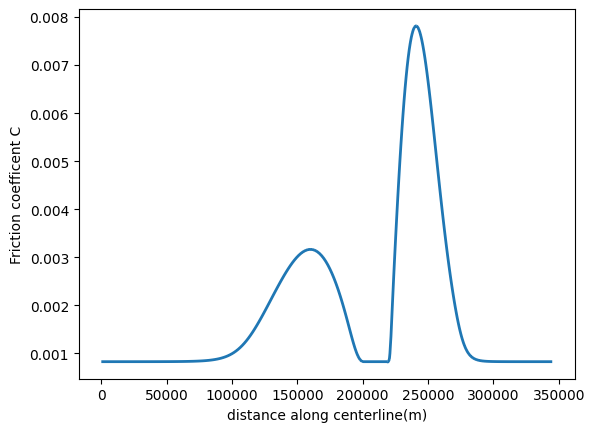

In [55]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline(m)")
axes.set_ylabel("Friction coefficent C")
firedrake.plot(icepack.depth_average(C), edgecolor="tab:blue", axes=axes);

$\phi$ = relative pressure at that point

$p_w =$ upward pressure of submerged ice

$p_I = $ downward pressure of unsubmerged ice

In [56]:
p_water = rho_water * g * max_value(0, h0 - s0) # Prevents negative thickness
p_ice = rho_ice * g * h0
phi = 1 - p_water / p_ice # Are there issues if phi = 0?"

#### Weertman friction
The law defines the driving stress as

$$
\tau_b = -C|u|^{\frac{1}{m}-1}u
$$

And the energy dissipation is

$$
E(u) = \int \frac{m}{m + 1}C|u|^{\frac{1}{m} + 1}dx.
$$

Weertman is already implemented in Icepack in the `icepack.models.hybrid.bed_friction(velocity = u, friction = C*phi)` function below.

#### Schoof friction approximation

This is implemented in the Synthetic Flowline Ice Stream tutorial as an approximation of the Schoof sliding law. When the velocity is small, energy dissipation acts relative to $|u|^1$, and when it is large, it acts relative to $|u|^{\frac{1}{m}+1}$. The factor $-U_0$ means that there is no flow when there is no energy dissipation.

$$
E(u) = \int \tau_0 \left( \left( U_0^{\frac{1}{m}+1}+|u|^{\frac{1}{m}+1}\right)^{\frac{m}{m+1}} - U_0 \right) dx
$$

In the implementation, $\tau_0$ is

$$
\tau_0 = C \left( U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}}\right)^{\frac{1}{m+1}}
$$

$\phi$ is implemented the same as above, where the amount of water displaced is the height of ice submerged $h_{sub} = h-s$

$$
\phi = 1 - \frac{\rho_{water}}{\rho_{ice}} \frac{(h_{sub})}{h_{supra}}
$$

Finally, friction is calculated as

$$
\tau_0 \times \phi \times \left(\left(U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}} \right)^{\frac{1}{m+1}} - U_0 \right)
$$


In [57]:
import icepack.models.hybrid

## Weertman friction
def weertman_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = firedrake.max_value(1 - p_water/p_ice, 0.2)
    # phi = 1
    
    return icepack.models.hybrid.bed_friction(
        velocity = u,
        friction = C * phi,
    )

from firedrake import sqrt, inner

def schoof_approx_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    U_0 = firedrake.Constant(50)
    U = sqrt(inner(u,u)) # Supposed to be u0, does this work?
    tau_0 = firedrake.interpolate(
        C*( U_0**(1/weertman+1) + U**(1/weertman+1) )**(1/(weertman+1)), u.function_space()
    )
    
    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice

    U = sqrt(inner(u, u))
    return tau_0 * phi * (
        (U_0**(1/weertman+1) + U**(1/weertman+1))**(weertman/(weertman+1))-U_0
    )

Set up hybrid model solver with custom friction function and initialize the velocity field.

In [58]:
model = icepack.models.HybridModel(friction = weertman_friction)
opts = {
    "dirichlet_ids": [1],
    # "diagnostic_solver_type": "petsc",
    # "diagnostic_solver_parameters": {"snes_type": "newtontr"},
}

solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity = u0,
    thickness = h0,
    surface = s0,
    fluidity = A,
    friction = C,
)

Plot new initial velocities.

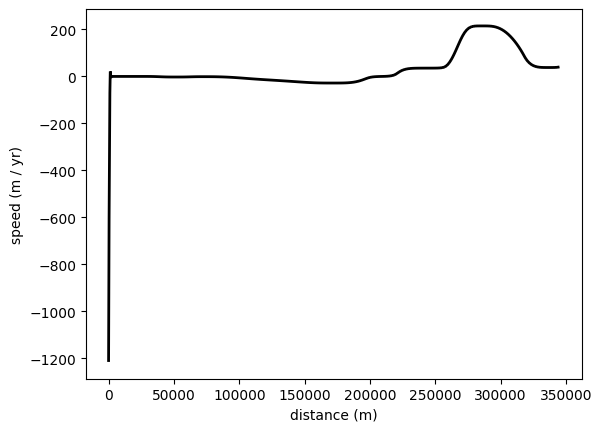

In [59]:
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes);

# print(u0.dat.data)

Define mass-balance function

In [60]:
from firedrake import ln, exp
def mass_balance(mb_h, mb_Q):
    mb_max = 8
    mb_sea = -2
    ELA = 200
    mb_k = 0.005
    mb_gradient = -mb_sea/ELA
    z_threshold = mb_max/mb_gradient + ELA
    
    mb_a = firedrake.interpolate(mb_gradient*((mb_h-ELA) - 1/(2*mb_k) * ln(1+exp(2*mb_k*(mb_h - z_threshold)))), mb_Q)
    # mb_a = firedrake.interpolate((mb_gradient * (mb_h - 1/(2*mb_k) * ln(1 + exp(2*mb_k*(mb_h - z_threshold)))),mb_Q)
    return mb_a

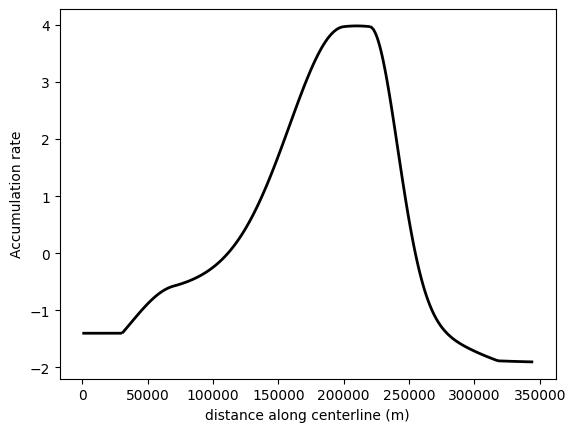

In [61]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("Accumulation rate")
firedrake.plot(icepack.depth_average(mass_balance(s0,Q)), axes=axes);

Define functions to vary the size of the model.

In [62]:
from scipy.interpolate import interp1d
import xarray

def shrink_function(func_src, nx, Lx_src, Lx_dest, funcspace_dest):
    # Pull out list of values from func_src
    f_data_src = func_src.dat.data
    
    # Initialize linspace lists with lengths Lx_src and Lx_dest
    f_data_len = len(f_data_src)
    f_ls_src = np.linspace(0, Lx_src, f_data_len, endpoint=True) # Adj to change left hand
    f_ls_dest= np.linspace(0, Lx_dest, f_data_len, endpoint=True) # Adj to change left hand
    
    # Interpolate f_data_src from f_ls_src to f_ls_dest
    f_interpolator = interp1d(f_ls_src, f_data_src, kind='linear', fill_value='extrapolate')
    f_data_dest = f_interpolator(f_ls_dest)
    
    # Convert f_data_dest into a firedrake function on destination function space funcspace_dest
    temp_dest = xarray.DataArray(f_data_dest, [f_ls_dest], 'x')
    func_dest = icepack.interpolate(temp_dest, funcspace_dest)

    func_dest.dat.data[-1] = temp_dest[-1]
    
    return func_dest

In [63]:
def shrink_model(nx, Lx_src, Lx_dest, h_src, u_src, a_src, h0_src, b_src, s_src, C_src):
    # Initialize mesh and mesh spaces
    mesh1d_dest = firedrake.IntervalMesh(nx, Lx_dest)
    mesh_dest = firedrake.ExtrudedMesh(mesh1d_dest, layers=1)
    Q_dest = firedrake.FunctionSpace(mesh_dest, "CG", 2, vfamily="R", vdegree=0)
    V_dest = firedrake.FunctionSpace(mesh_dest, "CG", 2, vfamily="GL", vdegree=0)
    
    # Remesh all functions
    h_dest =  shrink_function(h_src,  nx, Lx_src, Lx_dest, Q_dest)
    u_dest =  shrink_function(u_src,  nx, Lx_src, Lx_dest, V_dest)
    a_dest =  shrink_function(a_src,  nx, Lx_src, Lx_dest, Q_dest)
    h0_dest = shrink_function(h0_src, nx, Lx_src, Lx_dest, Q_dest)
    b_dest =  shrink_function(b_src,  nx, Lx_src, Lx_dest, Q_dest)
    s_dest =  shrink_function(s_src,  nx, Lx_src, Lx_dest, Q_dest)
    C_dest =  shrink_function(C_src,  nx, Lx_src, Lx_dest, Q_dest)
    # x_dest =  shrink_function(x_src,  nx, Lx_src, Lx_dest, Q_dest)
    x_dest, z_dest = firedrake.SpatialCoordinate(mesh_dest)
    
    return Q_dest, V_dest, h_dest, u_dest, a_dest, h0_dest, b_dest, s_dest, C_dest, x_dest

In [64]:
def find_endpoint_haf(src_lx, src_nx, src_h, src_s, src_Q, src_x):
    zb_end = firedrake.interpolate(src_s-src_h, src_Q)
    # zb_end = src_b
    float_h = firedrake.interpolate(-rho_water/rho_ice*zb_end, src_Q)
    h_above_f = firedrake.interpolate(conditional(lt(src_x,Lx_l), 10, src_h - float_h), src_Q)
    # Add conditional to make sure terminus isn't cut into land-terminating side

    haf_dat = h_above_f.dat.data
    x_dat = np.linspace(0, src_lx, len(src_h.dat.data), endpoint=True) # Adj to change left hand
    haf_interpolator = interp1d(haf_dat, x_dat, fill_value='extrapolate')
    L_new = haf_interpolator(5)
    # print(haf_dat)
    return L_new

    # zb = firedrake.interpolate(model_s-model_h, model_Q)

In [65]:
# Test endpoint function, should be a positive number, around where the ice meets the water.
test_haf_pt = find_endpoint_haf(Lx, nx, h0, s0, Q, x)
print(test_haf_pt)

312311.22314232157


In [66]:
def zero_terminus(src_x, src_Lx_l, src_h, src_Q):
    # If in the land-terminating area
        # if height < 10, make height ten
        # else retain height
    # else retain height
    fixed_h = firedrake.interpolate(conditional(lt(src_x, src_Lx_l), conditional(lt(src_h, 10), 10, src_h), src_h), src_Q)
    return fixed_h

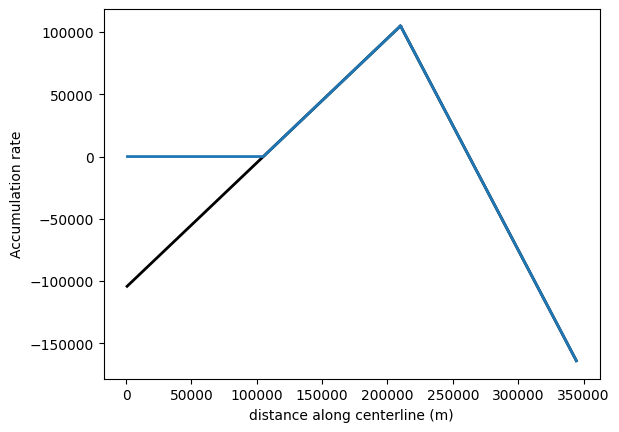

In [67]:
# Test terminus function
t_test_shape_0 = firedrake.interpolate(conditional(lt(x,Lx_l), x-Lx_l/2, Lx_l*2.5-2*x), Q)
t_test_shape_1 = zero_terminus(x, Lx_l, t_test_shape_0, Q)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("Accumulation rate")
firedrake.plot(icepack.depth_average(t_test_shape_0), axes=axes);
firedrake.plot(icepack.depth_average(t_test_shape_1), edgecolor="tab:blue", axes=axes);

### Run the actual model

In [68]:
# Set up model parameters
num_years = 100
timesteps_per_year = 2
snapshot_location = [0, 10, 20, 30, 40]
height_snapshots = []
velocity_snapshots = []

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

# a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q) # Ramping accumulation along length
a = mass_balance(s0, Q) # Mass balance variable by elevation
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)
s = s0.copy(deepcopy = True)

# Copy initial lengths, use shrink_model to copy functions and function spaces
model_nx = nx
model_Lx_l = Lx_l
model_Lx_r = Lx_r
model_Lx = Lx

model_Q, model_V, model_h, model_u, model_a, model_h0, model_b, model_s, model_C, model_x = shrink_model(
    nx, Lx, Lx, h, u, a, h0, b, s, C)

# Initialize new solver
loop_model = icepack.models.HybridModel(friction = schoof_approx_friction)
model_solver = icepack.solvers.FlowSolver(loop_model, **opts)

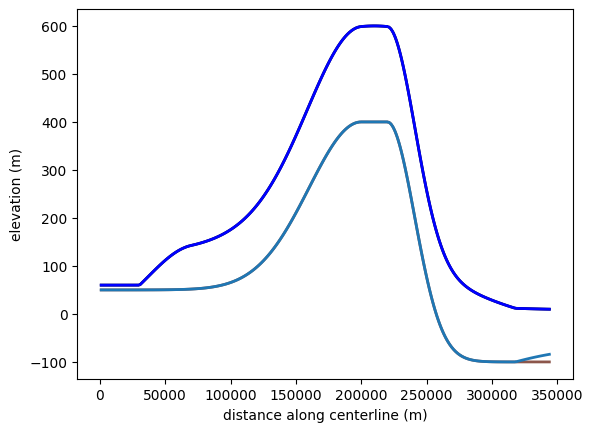

In [69]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(model_b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(model_s-model_h, model_Q)
firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s0), axes=axes);
firedrake.plot(icepack.depth_average(model_s), edgecolor = 'b', axes=axes);

In [70]:
# Run the model loop
import tqdm
for step in tqdm.trange(num_timesteps):
    # snapshots.append(model_s.copy(deepcopy=True))
    model_h = model_solver.prognostic_solve(
        dt,
        thickness = model_h,
        velocity = model_u,
        accumulation = model_a,
        thickness_inflow = model_h0,
    )

    # h = icepack.interpolate(conditional(lt(h,h_calving),h_min,h),Q) # Calving to minimum stable value (use UFL for functions)

    model_h = zero_terminus(model_x, model_Lx_l, model_h, model_Q)
    model_s = icepack.compute_surface(thickness=model_h, bed=model_b)
    model_a = mass_balance(model_s, model_Q)

    # snapshots.append(model_s.copy(deepcopy=True))
    # print(model_Lx)

    temp_Lx = find_endpoint_haf(model_Lx, nx, model_h, model_s, model_Q, model_x)
    # print(temp_Lx)
    model_Q, model_V, model_h, model_u, model_a, model_h0, model_b, model_s, model_C, model_x = shrink_model(
        model_nx, model_Lx, temp_Lx, model_h, model_u, model_a, model_h0, model_b, model_s, model_C)
    model_Lx = temp_Lx

    # print(model_Lx)
    # snapshots.append(model_s.copy(deepcopy=True))

    loop_model = icepack.models.HybridModel(friction = schoof_approx_friction)
    model_solver = icepack.solvers.FlowSolver(loop_model, **opts)
    
    model_u = model_solver.diagnostic_solve(
        velocity = model_u,
        thickness = model_h,
        surface = model_s,
        fluidity = A,
        friction = model_C,
    )

    # snapshots.append(model_s.copy(deepcopy=True))
    
    if (step in snapshot_location):
        print("saving snapshot")
        height_snapshots.append(model_s.copy(deepcopy=True))
        velocity_snapshots.append(model_u.copy(deepcopy=True))
        # It would be nice to append a 0 onto the end of each snapshot for visualization
        # snapshots[-1].dat.data[-1] = model_b.dat.data[-1]

  0%|▎                                                 | 1/200 [00:00<02:36,  1.27it/s]

saving snapshot


  6%|██▋                                              | 11/200 [00:10<02:36,  1.20it/s]

saving snapshot


 10%|█████▏                                           | 21/200 [00:18<02:16,  1.32it/s]

saving snapshot


 14%|██████▌                                          | 27/200 [00:23<02:32,  1.13it/s]


ConvergenceError: Minimization solver has invalid search direction. This is likely due to a negative thickness or friction coefficient orotherwise physically invalid input data.

Plot profile.

IndexError: list index out of range

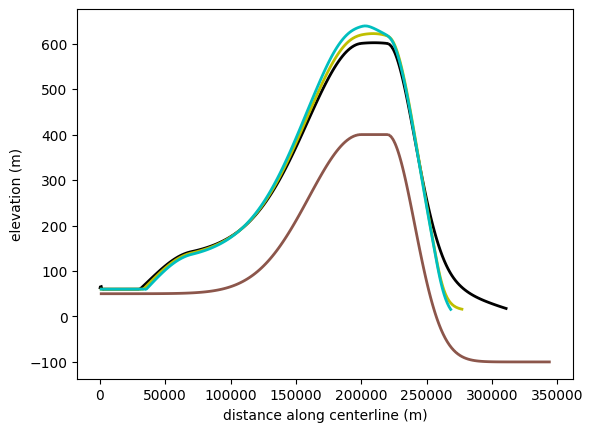

In [73]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(model_s-model_h, model_Q)
# firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)

firedrake.plot(icepack.depth_average(height_snapshots[0]), edgecolor = '0', axes=axes)
firedrake.plot(icepack.depth_average(height_snapshots[1]), edgecolor = 'y', axes=axes)
firedrake.plot(icepack.depth_average(height_snapshots[2]), edgecolor = 'c', axes=axes)
firedrake.plot(icepack.depth_average(height_snapshots[3]), edgecolor = 'g', axes=axes)
# firedrake.plot(icepack.depth_average(model_s), edgecolor = 'b', axes=axes);

IndexError: list index out of range

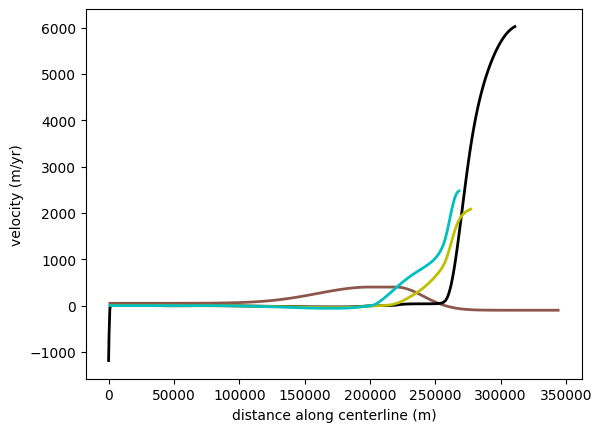

In [74]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)

firedrake.plot(icepack.depth_average(velocity_snapshots[0]), edgecolor = '0', axes=axes)
firedrake.plot(icepack.depth_average(velocity_snapshots[1]), edgecolor = 'y', axes=axes)
firedrake.plot(icepack.depth_average(velocity_snapshots[2]), edgecolor = 'c', axes=axes)
firedrake.plot(icepack.depth_average(velocity_snapshots[3]), edgecolor = 'g', axes=axes)
# firedrake.plot(icepack.depth_average(model_u), edgecolor = 'b', axes=axes);

In [ ]:
print(u.dat.data)